<a href="https://colab.research.google.com/github/AIWintermuteAI/Seeed_Python_MachineLearning/blob/main/jupyter_notebooks/aXeleRate_face_anti_spoofing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Face anti-spoofing model Training and Inference

In this notebook we will use aXeleRate, Keras-based framework for AI on the edge to quickly setup model training and then after training session is completed convert it to .tflite and other formats.

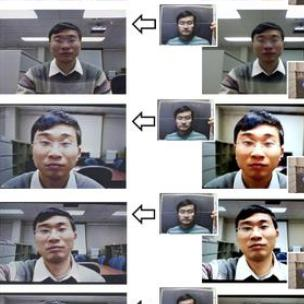

Facial anti-spoofing is the task of preventing false facial verification by using a photo, video, mask or a different substitute for an authorized person’s face. Some examples of attacks:

- Print attack: The attacker uses someone’s photo. The image is printed or displayed on a digital device.

- Replay/video attack: A more sophisticated way to trick the system, which usually requires a looped video of a victim’s face. This approach ensures behaviour and facial movements to look more ‘natural’ compared to holding someone’s photo.

- 3D mask attack: During this type of attack, a mask is used as the tool of choice for spoofing. It’s an even more sophisticated attack than playing a face video. In addition to natural facial movements, it enables ways to deceive some extra layers of protection such as depth sensors.

In this notebook we'll train a relatively simple MobileNet v1 alpha 0.25 based Classifier to distinguish between cropped pictures of real and spoofed faces.

First, let's take care of some administrative details. 

1) Before we do anything, make sure you have choosen GPU as Runtime type (in Runtime - > Change Runtime type).

2) We need to mount Google Drive for saving our model checkpoints and final converted model(s). Press on Mount Google Drive button in Files tab on your left. 

In the next cell we clone axelerate Github repository and import it. 

**It is possible to use pip install or python setup.py install, but in that case you will need to restart the enironment.** Since I'm trying to make the process as streamlined as possibile I'm using sys.path.append for import.

In [ ]:
#we need imgaug 0.4 for image augmentations to work properly, see https://stackoverflow.com/questions/62580797/in-colab-doing-image-data-augmentation-with-imgaug-is-not-working-as-intended
!pip uninstall -y imgaug && pip uninstall -y albumentations && pip install imgaug==0.4
!git clone https://github.com/AIWintermuteAI/aXeleRate.git
import sys
sys.path.append('/content/aXeleRate')
from axelerate import setup_training, setup_inference

At this step you typically need to get the dataset. You can use !wget command to download it from somewhere on the Internet or !cp to copy from My Drive as in this example
```
!cp -r /content/drive/'My Drive'/pascal_20_segmentation.zip .
!unzip --qq pascal_20_segmentation.zip
```
For this notebook we will use a mixture of face anti-spoofing public datasets, along with a few images collected manually for testing purposes. The datasets used for training and validation are:
- NUAA Photograph Imposter Database **from**
X.Tan, Y.Li, J.Liu and L.Jiang.
Face Liveness Detection from A Single Image with Sparse Low Rank Bilinear Discriminative Model, 
In: Proceedings of 11th European Conference on Computer Vision (ECCV'10), Crete, Greece. September 2010
-  CASIA-MFSD **Introduced by** Zhiwei Zhang et al. in A face antispoofing database with diverse attacks

The frames extracted from CASIA-MFSD videos are then processed to extract and crop faces with 0.0 margin around the face (no margin, tight crop) to match cropped images from NUAA Photograph Imposter Database. 

For validation, 32 real and 32 fake face images were randomly sampled from subjects 29,30 and pictures taken with Notebook authors phone of himself.

In the next cell we will download the same dataset, with training/validation split already done - I shared on my Google Drive. We will also download pre-trained model to demonstrate inference results. Please note, that dataset license ONLY allows non-commercial usage.

Let's visualize our classification validation dataset with visualize_dataset function, which will search for all images in folder and display num_imgs number of images with class overlayer over the image.


In [ ]:
%matplotlib inline
!gdown https://drive.google.com/uc?id=1Mgl5ryl2Ac_rZ8cF_f9z6AKR6O1VCZUh
!unzip --qq face_anti-spoofing.zip

from axelerate.networks.common_utils.augment import visualize_classification_dataset

visualize_classification_dataset('face_anti-spoofing/imgs_validation', num_imgs=10, img_size=128, augment=False)

Next step is defining a config dictionary. Most lines are self-explanatory.

Type is model frontend - Classifier, Detector or Segnet

Architecture is model backend (feature extractor) 

- Full Yolo
- Tiny Yolo
- MobileNet1_0
- MobileNet7_5 
- MobileNet5_0 
- MobileNet2_5 
- SqueezeNet
- NASNetMobile
- DenseNet121
- ResNet50

**Note that while you can train any network type with any backend (Tiny YOLO + Classifier, NASNETMobile +  Detector, DenseNet121 + Segnet and so on), some converters do not support larger networks! E.g. K210 converter only supports MobileNet and TinyYOLO backends.**

Fully_connected is number of neurons in classification layers as list.

Dropout value is dropout in classification layers.

actual_epoch is number of epochs to train, noramlly good starting value is 50 - 100

train_times is a multiplier for training dataset, i.e. how many times to repeat the dataset during one epoch. Useful when you apply augmentations to image. Normally between 1 and 3 is okay. If you have big dataset, can leave at 1.

For converter type you can choose the following:

'k210', 'tflite_fullint', 'tflite_dynamic', 'edgetpu', 'openvino', 'onnx'

In [ ]:
config = {
    "model" : {
        "type":                 "Classifier",
        "architecture":         "MobileNet2_5",
        "input_size":           128,
        "fully-connected":      [],
        "labels":               [],
        "dropout" : 		        0.2
    },
     "weights" : {
            "full":   				  "",
            "backend":   		    "imagenet",
            "save_bottleneck":   False
        
    },
    "train" : {
        "actual_epoch":         10,
        "train_image_folder":   "face_anti-spoofing/imgs",
        "train_times":          1,
        "valid_image_folder":   "face_anti-spoofing/imgs_validation",
        "valid_times":          1,
        "valid_metric":         "val_accuracy",
        "batch_size":           32,
        "learning_rate":        1e-3,
        "saved_folder":   		F"/content/drive/MyDrive/projects/face_anti-spoofing",
        "first_trainable_layer": "",
        "augumentation":				True
    },
    "converter" : {
        "type":   				["tflite_dynamic"]
    }
}

Let's check what GPU we have been assigned in this Colab session, if any.

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Also, let's open Tensorboard, where we will be able to watch model training progress in real time. Training and validation logs also will be saved in project folder.
Since there are no logs before we start the training, tensorboard will be empty. Refresh it after first epoch.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs
!sleep 10

Finally we start the training by passing config dictionary we have defined earlier to setup_training function. The function will start the training with Checkpoint, Reduce Learning Rate on Plateu and Early Stopping callbacks. Every time our validation metric(in this config set to "val_accuracy") improves, the model is saved with Checkpoint callback. If you have specified the converter type in the config, after the training has stopped the script will convert the best model into the format you have specified in config and save it to the project folder.

In [ ]:
from keras import backend as K 
K.clear_session()
model_path = setup_training(config_dict=config)

After training it is good to check the actual perfomance of your model by doing inference on your validation dataset and visualizing results. This is exactly what next block does. After 10 epochs the accuracy should be at about 0.93 percent.
If you'd like to use the trained model on Raspberry Pi or reTerminal (Raspberry Pi 4 CM based development board), copy the .tflite model to the board and use 
scripts here
https://github.com/AIWintermuteAI/aXeleRate/tree/master/example_scripts/tensorflow_lite/classifier
for running inference on the device.

In [ ]:
%matplotlib inline
from keras import backend as K 
K.clear_session()
setup_inference(config, model_path)

If you need to convert trained model to other formats, for example for inference with Edge TPU or Kendryte K210, you can do it with following commands. Specify the converter type, backend and folder with calbiration images(normally your validation image folder).

In [ ]:
from axelerate.networks.common_utils.convert import Converter
converter = Converter('k210', 'MobileNet2_5', 'face_anti-spoofing/imgs_validation')
converter.convert_model(model_path)

Good luck and happy training! Have a look at these articles, that would allow you to get the most of Google Colab or connect to local runtime if there are no GPUs available;

https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403

https://research.google.com/colaboratory/local-runtimes.html